In [ ]:
# MAIN TODO:
#     - put validation set as early stopping 
#     - show loss functions decrease through epochs (train, test and val) DONE 
#     - put optuna
#     - show correct and incorrect predictions


# Imports

In [60]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions

In [66]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

# Setup

In [50]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [51]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


# Def MLP

In [52]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_function):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.fc_input   = nn.Linear(in_features=input_size, out_features=64)
        self.fc_hidden1 = nn.Linear(in_features=64, out_features=128)
        self.fc_hidden2 = nn.Linear(in_features=128, out_features=64)
        self.fc_output  = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.activation_function(self.fc_input(x))
        x = self.activation_function(self.fc_hidden1(x))
        x = self.activation_function(self.fc_hidden2(x))
        x = self.fc_output(x)
        return x 

# Def hyperparameters and Loaders

In [53]:
input_size          = 32*32*3
num_classes         = 10

# TODO: let this params manipulated
learning_rate       = 0.001
num_epochs          = 100
batch_size          = 16
activation_function = nn.ReLU()

loss_function       = nn.CrossEntropyLoss()

In [54]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # to avoid bias
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Main training Loop

In [59]:
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

best_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, validation_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'  Train Loss: {train_loss:.4f}')
    tqdm.write(f'  Val Loss: {val_loss:.4f}')
    tqdm.write(f'  Test Loss: {test_loss:.4f}')


    # early stopping 
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping based on loss reduction through epochs")
            break



  1%|          | 1/100 [00:00<00:25,  3.83it/s]

Epoch 1:
  Train Loss: 2.3052
  Val Loss: 2.3020
  Test Loss: 2.3070


  2%|▏         | 2/100 [00:00<00:25,  3.85it/s]

Epoch 2:
  Train Loss: 2.3044
  Val Loss: 2.3013
  Test Loss: 2.3062


  3%|▎         | 3/100 [00:00<00:25,  3.80it/s]

Epoch 3:
  Train Loss: 2.3036
  Val Loss: 2.3006
  Test Loss: 2.3054


  4%|▍         | 4/100 [00:01<00:25,  3.78it/s]

Epoch 4:
  Train Loss: 2.3026
  Val Loss: 2.2999
  Test Loss: 2.3047


  5%|▌         | 5/100 [00:01<00:25,  3.78it/s]

Epoch 5:
  Train Loss: 2.3014
  Val Loss: 2.2993
  Test Loss: 2.3040


  6%|▌         | 6/100 [00:01<00:24,  3.76it/s]

Epoch 6:
  Train Loss: 2.3001
  Val Loss: 2.2986
  Test Loss: 2.3032


  7%|▋         | 7/100 [00:01<00:25,  3.72it/s]

Epoch 7:
  Train Loss: 2.2992
  Val Loss: 2.2979
  Test Loss: 2.3025


  8%|▊         | 8/100 [00:02<00:24,  3.75it/s]

Epoch 8:
  Train Loss: 2.2979
  Val Loss: 2.2973
  Test Loss: 2.3018


  9%|▉         | 9/100 [00:02<00:24,  3.79it/s]

Epoch 9:
  Train Loss: 2.2974
  Val Loss: 2.2966
  Test Loss: 2.3011


 10%|█         | 10/100 [00:02<00:24,  3.68it/s]

Epoch 10:
  Train Loss: 2.2964
  Val Loss: 2.2959
  Test Loss: 2.3003


 11%|█         | 11/100 [00:02<00:24,  3.62it/s]

Epoch 11:
  Train Loss: 2.2953
  Val Loss: 2.2952
  Test Loss: 2.2995


 12%|█▏        | 12/100 [00:03<00:25,  3.48it/s]

Epoch 12:
  Train Loss: 2.2942
  Val Loss: 2.2944
  Test Loss: 2.2987


 13%|█▎        | 13/100 [00:03<00:24,  3.57it/s]

Epoch 13:
  Train Loss: 2.2925
  Val Loss: 2.2936
  Test Loss: 2.2979


 14%|█▍        | 14/100 [00:03<00:23,  3.59it/s]

Epoch 14:
  Train Loss: 2.2916
  Val Loss: 2.2928
  Test Loss: 2.2970


 15%|█▌        | 15/100 [00:04<00:23,  3.66it/s]

Epoch 15:
  Train Loss: 2.2904
  Val Loss: 2.2920
  Test Loss: 2.2961


 16%|█▌        | 16/100 [00:04<00:22,  3.68it/s]

Epoch 16:
  Train Loss: 2.2890
  Val Loss: 2.2911
  Test Loss: 2.2951


 17%|█▋        | 17/100 [00:04<00:22,  3.75it/s]

Epoch 17:
  Train Loss: 2.2875
  Val Loss: 2.2902
  Test Loss: 2.2942


 18%|█▊        | 18/100 [00:04<00:21,  3.79it/s]

Epoch 18:
  Train Loss: 2.2861
  Val Loss: 2.2892
  Test Loss: 2.2931


 19%|█▉        | 19/100 [00:05<00:21,  3.83it/s]

Epoch 19:
  Train Loss: 2.2846
  Val Loss: 2.2882
  Test Loss: 2.2921


 20%|██        | 20/100 [00:05<00:20,  3.85it/s]

Epoch 20:
  Train Loss: 2.2832
  Val Loss: 2.2872
  Test Loss: 2.2910


 21%|██        | 21/100 [00:05<00:20,  3.77it/s]

Epoch 21:
  Train Loss: 2.2815
  Val Loss: 2.2861
  Test Loss: 2.2899


 22%|██▏       | 22/100 [00:05<00:20,  3.79it/s]

Epoch 22:
  Train Loss: 2.2801
  Val Loss: 2.2850
  Test Loss: 2.2887


 23%|██▎       | 23/100 [00:06<00:20,  3.78it/s]

Epoch 23:
  Train Loss: 2.2779
  Val Loss: 2.2838
  Test Loss: 2.2875


 24%|██▍       | 24/100 [00:06<00:19,  3.83it/s]

Epoch 24:
  Train Loss: 2.2759
  Val Loss: 2.2826
  Test Loss: 2.2863


 25%|██▌       | 25/100 [00:06<00:19,  3.85it/s]

Epoch 25:
  Train Loss: 2.2744
  Val Loss: 2.2814
  Test Loss: 2.2850


 26%|██▌       | 26/100 [00:06<00:19,  3.87it/s]

Epoch 26:
  Train Loss: 2.2725
  Val Loss: 2.2801
  Test Loss: 2.2836


 27%|██▋       | 27/100 [00:07<00:18,  3.88it/s]

Epoch 27:
  Train Loss: 2.2707
  Val Loss: 2.2788
  Test Loss: 2.2823


 28%|██▊       | 28/100 [00:07<00:18,  3.88it/s]

Epoch 28:
  Train Loss: 2.2686
  Val Loss: 2.2775
  Test Loss: 2.2808


 29%|██▉       | 29/100 [00:07<00:18,  3.77it/s]

Epoch 29:
  Train Loss: 2.2673
  Val Loss: 2.2761
  Test Loss: 2.2794


 30%|███       | 30/100 [00:07<00:18,  3.76it/s]

Epoch 30:
  Train Loss: 2.2649
  Val Loss: 2.2747
  Test Loss: 2.2779


 31%|███       | 31/100 [00:08<00:18,  3.78it/s]

Epoch 31:
  Train Loss: 2.2629
  Val Loss: 2.2732
  Test Loss: 2.2764


 32%|███▏      | 32/100 [00:08<00:18,  3.63it/s]

Epoch 32:
  Train Loss: 2.2603
  Val Loss: 2.2717
  Test Loss: 2.2748


 33%|███▎      | 33/100 [00:08<00:18,  3.67it/s]

Epoch 33:
  Train Loss: 2.2588
  Val Loss: 2.2702
  Test Loss: 2.2731


 34%|███▍      | 34/100 [00:09<00:17,  3.68it/s]

Epoch 34:
  Train Loss: 2.2559
  Val Loss: 2.2686
  Test Loss: 2.2715


 35%|███▌      | 35/100 [00:09<00:17,  3.71it/s]

Epoch 35:
  Train Loss: 2.2540
  Val Loss: 2.2670
  Test Loss: 2.2698


 36%|███▌      | 36/100 [00:09<00:17,  3.70it/s]

Epoch 36:
  Train Loss: 2.2514
  Val Loss: 2.2654
  Test Loss: 2.2681


 37%|███▋      | 37/100 [00:09<00:17,  3.69it/s]

Epoch 37:
  Train Loss: 2.2488
  Val Loss: 2.2637
  Test Loss: 2.2663


 38%|███▊      | 38/100 [00:10<00:16,  3.72it/s]

Epoch 38:
  Train Loss: 2.2476
  Val Loss: 2.2621
  Test Loss: 2.2646


 39%|███▉      | 39/100 [00:10<00:16,  3.74it/s]

Epoch 39:
  Train Loss: 2.2432
  Val Loss: 2.2604
  Test Loss: 2.2627


 40%|████      | 40/100 [00:10<00:16,  3.71it/s]

Epoch 40:
  Train Loss: 2.2412
  Val Loss: 2.2587
  Test Loss: 2.2609


 41%|████      | 41/100 [00:10<00:15,  3.72it/s]

Epoch 41:
  Train Loss: 2.2383
  Val Loss: 2.2571
  Test Loss: 2.2591


 42%|████▏     | 42/100 [00:11<00:15,  3.72it/s]

Epoch 42:
  Train Loss: 2.2360
  Val Loss: 2.2554
  Test Loss: 2.2573


 43%|████▎     | 43/100 [00:11<00:15,  3.74it/s]

Epoch 43:
  Train Loss: 2.2340
  Val Loss: 2.2537
  Test Loss: 2.2555


 44%|████▍     | 44/100 [00:11<00:14,  3.76it/s]

Epoch 44:
  Train Loss: 2.2306
  Val Loss: 2.2521
  Test Loss: 2.2537


 45%|████▌     | 45/100 [00:12<00:14,  3.72it/s]

Epoch 45:
  Train Loss: 2.2275
  Val Loss: 2.2504
  Test Loss: 2.2519


 46%|████▌     | 46/100 [00:12<00:14,  3.78it/s]

Epoch 46:
  Train Loss: 2.2261
  Val Loss: 2.2488
  Test Loss: 2.2501


 47%|████▋     | 47/100 [00:12<00:13,  3.82it/s]

Epoch 47:
  Train Loss: 2.2238
  Val Loss: 2.2472
  Test Loss: 2.2483


 48%|████▊     | 48/100 [00:12<00:13,  3.85it/s]

Epoch 48:
  Train Loss: 2.2207
  Val Loss: 2.2456
  Test Loss: 2.2466


 49%|████▉     | 49/100 [00:13<00:13,  3.83it/s]

Epoch 49:
  Train Loss: 2.2186
  Val Loss: 2.2440
  Test Loss: 2.2448


 50%|█████     | 50/100 [00:13<00:13,  3.67it/s]

Epoch 50:
  Train Loss: 2.2166
  Val Loss: 2.2424
  Test Loss: 2.2431


 51%|█████     | 51/100 [00:13<00:13,  3.66it/s]

Epoch 51:
  Train Loss: 2.2142
  Val Loss: 2.2407
  Test Loss: 2.2414


 52%|█████▏    | 52/100 [00:13<00:13,  3.66it/s]

Epoch 52:
  Train Loss: 2.2114
  Val Loss: 2.2391
  Test Loss: 2.2396


 53%|█████▎    | 53/100 [00:14<00:12,  3.72it/s]

Epoch 53:
  Train Loss: 2.2086
  Val Loss: 2.2374
  Test Loss: 2.2379


 54%|█████▍    | 54/100 [00:14<00:12,  3.71it/s]

Epoch 54:
  Train Loss: 2.2064
  Val Loss: 2.2357
  Test Loss: 2.2361


 55%|█████▌    | 55/100 [00:14<00:12,  3.70it/s]

Epoch 55:
  Train Loss: 2.2039
  Val Loss: 2.2341
  Test Loss: 2.2344


 56%|█████▌    | 56/100 [00:14<00:11,  3.75it/s]

Epoch 56:
  Train Loss: 2.2006
  Val Loss: 2.2323
  Test Loss: 2.2326


 57%|█████▋    | 57/100 [00:15<00:11,  3.67it/s]

Epoch 57:
  Train Loss: 2.1981
  Val Loss: 2.2306
  Test Loss: 2.2308


 58%|█████▊    | 58/100 [00:15<00:11,  3.68it/s]

Epoch 58:
  Train Loss: 2.1973
  Val Loss: 2.2288
  Test Loss: 2.2289


 59%|█████▉    | 59/100 [00:15<00:11,  3.69it/s]

Epoch 59:
  Train Loss: 2.1940
  Val Loss: 2.2270
  Test Loss: 2.2270


 60%|██████    | 60/100 [00:16<00:10,  3.68it/s]

Epoch 60:
  Train Loss: 2.1916
  Val Loss: 2.2252
  Test Loss: 2.2251


 61%|██████    | 61/100 [00:16<00:10,  3.69it/s]

Epoch 61:
  Train Loss: 2.1880
  Val Loss: 2.2234
  Test Loss: 2.2232


 62%|██████▏   | 62/100 [00:16<00:11,  3.45it/s]

Epoch 62:
  Train Loss: 2.1877
  Val Loss: 2.2214
  Test Loss: 2.2212


 63%|██████▎   | 63/100 [00:16<00:10,  3.50it/s]

Epoch 63:
  Train Loss: 2.1841
  Val Loss: 2.2194
  Test Loss: 2.2191


 64%|██████▍   | 64/100 [00:17<00:10,  3.52it/s]

Epoch 64:
  Train Loss: 2.1806
  Val Loss: 2.2176
  Test Loss: 2.2171


 65%|██████▌   | 65/100 [00:17<00:09,  3.58it/s]

Epoch 65:
  Train Loss: 2.1769
  Val Loss: 2.2155
  Test Loss: 2.2150


 66%|██████▌   | 66/100 [00:17<00:09,  3.62it/s]

Epoch 66:
  Train Loss: 2.1754
  Val Loss: 2.2134
  Test Loss: 2.2128


 67%|██████▋   | 67/100 [00:18<00:08,  3.68it/s]

Epoch 67:
  Train Loss: 2.1732
  Val Loss: 2.2113
  Test Loss: 2.2106


 68%|██████▊   | 68/100 [00:18<00:08,  3.69it/s]

Epoch 68:
  Train Loss: 2.1707
  Val Loss: 2.2090
  Test Loss: 2.2083


 69%|██████▉   | 69/100 [00:18<00:08,  3.62it/s]

Epoch 69:
  Train Loss: 2.1676
  Val Loss: 2.2069
  Test Loss: 2.2060


 70%|███████   | 70/100 [00:18<00:08,  3.66it/s]

Epoch 70:
  Train Loss: 2.1647
  Val Loss: 2.2045
  Test Loss: 2.2036


 71%|███████   | 71/100 [00:19<00:07,  3.66it/s]

Epoch 71:
  Train Loss: 2.1624
  Val Loss: 2.2023
  Test Loss: 2.2012


 72%|███████▏  | 72/100 [00:19<00:07,  3.69it/s]

Epoch 72:
  Train Loss: 2.1588
  Val Loss: 2.2000
  Test Loss: 2.1988


 73%|███████▎  | 73/100 [00:19<00:07,  3.76it/s]

Epoch 73:
  Train Loss: 2.1555
  Val Loss: 2.1977
  Test Loss: 2.1964


 74%|███████▍  | 74/100 [00:19<00:06,  3.81it/s]

Epoch 74:
  Train Loss: 2.1527
  Val Loss: 2.1952
  Test Loss: 2.1938


 75%|███████▌  | 75/100 [00:20<00:06,  3.86it/s]

Epoch 75:
  Train Loss: 2.1505
  Val Loss: 2.1928
  Test Loss: 2.1912


 76%|███████▌  | 76/100 [00:20<00:06,  3.88it/s]

Epoch 76:
  Train Loss: 2.1474
  Val Loss: 2.1902
  Test Loss: 2.1886


 77%|███████▋  | 77/100 [00:20<00:05,  3.88it/s]

Epoch 77:
  Train Loss: 2.1428
  Val Loss: 2.1877
  Test Loss: 2.1859


 78%|███████▊  | 78/100 [00:20<00:05,  3.85it/s]

Epoch 78:
  Train Loss: 2.1420
  Val Loss: 2.1851
  Test Loss: 2.1831


 79%|███████▉  | 79/100 [00:21<00:05,  3.80it/s]

Epoch 79:
  Train Loss: 2.1373
  Val Loss: 2.1824
  Test Loss: 2.1803


 80%|████████  | 80/100 [00:21<00:05,  3.75it/s]

Epoch 80:
  Train Loss: 2.1325
  Val Loss: 2.1799
  Test Loss: 2.1776


 81%|████████  | 81/100 [00:21<00:05,  3.73it/s]

Epoch 81:
  Train Loss: 2.1321
  Val Loss: 2.1772
  Test Loss: 2.1747


 82%|████████▏ | 82/100 [00:22<00:04,  3.74it/s]

Epoch 82:
  Train Loss: 2.1267
  Val Loss: 2.1746
  Test Loss: 2.1718


 83%|████████▎ | 83/100 [00:22<00:04,  3.76it/s]

Epoch 83:
  Train Loss: 2.1231
  Val Loss: 2.1718
  Test Loss: 2.1688


 84%|████████▍ | 84/100 [00:22<00:04,  3.73it/s]

Epoch 84:
  Train Loss: 2.1211
  Val Loss: 2.1691
  Test Loss: 2.1659


 85%|████████▌ | 85/100 [00:22<00:04,  3.75it/s]

Epoch 85:
  Train Loss: 2.1165
  Val Loss: 2.1665
  Test Loss: 2.1629


 86%|████████▌ | 86/100 [00:23<00:03,  3.65it/s]

Epoch 86:
  Train Loss: 2.1151
  Val Loss: 2.1636
  Test Loss: 2.1599


 87%|████████▋ | 87/100 [00:23<00:03,  3.66it/s]

Epoch 87:
  Train Loss: 2.1081
  Val Loss: 2.1609
  Test Loss: 2.1568


 88%|████████▊ | 88/100 [00:23<00:03,  3.66it/s]

Epoch 88:
  Train Loss: 2.1089
  Val Loss: 2.1582
  Test Loss: 2.1538


 89%|████████▉ | 89/100 [00:23<00:03,  3.67it/s]

Epoch 89:
  Train Loss: 2.1043
  Val Loss: 2.1553
  Test Loss: 2.1507


 90%|█████████ | 90/100 [00:24<00:02,  3.68it/s]

Epoch 90:
  Train Loss: 2.1013
  Val Loss: 2.1524
  Test Loss: 2.1475


 91%|█████████ | 91/100 [00:24<00:02,  3.73it/s]

Epoch 91:
  Train Loss: 2.0942
  Val Loss: 2.1497
  Test Loss: 2.1445


 92%|█████████▏| 92/100 [00:24<00:02,  3.70it/s]

Epoch 92:
  Train Loss: 2.0957
  Val Loss: 2.1469
  Test Loss: 2.1414


 93%|█████████▎| 93/100 [00:25<00:01,  3.69it/s]

Epoch 93:
  Train Loss: 2.0880
  Val Loss: 2.1443
  Test Loss: 2.1384


 94%|█████████▍| 94/100 [00:25<00:01,  3.74it/s]

Epoch 94:
  Train Loss: 2.0858
  Val Loss: 2.1415
  Test Loss: 2.1354


 95%|█████████▌| 95/100 [00:25<00:01,  3.77it/s]

Epoch 95:
  Train Loss: 2.0846
  Val Loss: 2.1384
  Test Loss: 2.1321


 96%|█████████▌| 96/100 [00:25<00:01,  3.74it/s]

Epoch 96:
  Train Loss: 2.0804
  Val Loss: 2.1357
  Test Loss: 2.1291


 97%|█████████▋| 97/100 [00:26<00:00,  3.71it/s]

Epoch 97:
  Train Loss: 2.0768
  Val Loss: 2.1331
  Test Loss: 2.1261


 98%|█████████▊| 98/100 [00:26<00:00,  3.76it/s]

Epoch 98:
  Train Loss: 2.0733
  Val Loss: 2.1302
  Test Loss: 2.1230


 99%|█████████▉| 99/100 [00:26<00:00,  3.76it/s]

Epoch 99:
  Train Loss: 2.0700
  Val Loss: 2.1276
  Test Loss: 2.1200


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]

Epoch 100:
  Train Loss: 2.0658
  Val Loss: 2.1248
  Test Loss: 2.1170


# Evaluate best model

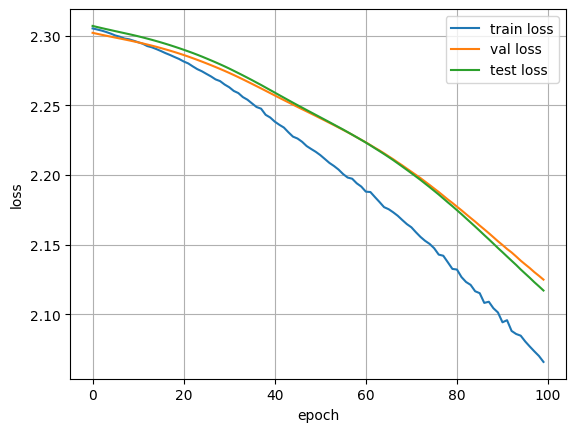

In [67]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

In [56]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}")

Scores of your model
 {'accuracy': 0.25, 'balanced_accuracy': np.float64(0.23600941118077995), 'f1_score': 0.19011906256618327, 'precision': 0.18987231047112701, 'recall': 0.25}


/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
